# Time for solving an issue in Gerrit 

In [3]:
import MySQLdb
import pandas

def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "lp_vs_gerrit_metrics"
   port=3306
   use_unicode=True

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db, port = port, use_unicode = use_unicode)
      return db, db.cursor()
   except:
      logging.error("Database connection error!")
      raise
        
def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    
db, cursor = connect()

### The next query focuses on collecting data for measuring the time to review the issues in Gerrit. 
For this we extract the issues that have been closed. 

In [11]:
query = """ select i.issue                       as gerrit_issue,  
                   t0.opening_date               as gerrit_opening_date,  
                   t1.closing_date               as gerrit_closing_date, 
                   timestampdiff(SECOND, t0.opening_date, t1.closing_date) as time2close, 
                   t.url                         as gerrit_tracker,
                   i.status                      as current_status 
            from issuesCR i, 
                 trackers t, 
                 changes ch, 
                 (select i.id as issue_id, 
                         ch.changed_on as closing_date 
                  from issuesCR i 
                    left join changes ch 
                    on ch.issue_id = i.id and 
                       field='status' and 
                       new_value='MERGED' ) t1, 
                 (select ch.issue_id, 
                         ch.changed_on as opening_date 
                  from changes ch 
                  where ch.field='status' and 
                        ch.new_value='UPLOADED' and 
                        ch.old_value=1) t0 
            where i.tracker_id=t.id and 
                  ch.issue_id = i.id and 
                  i.id=t0.issue_id  and 
                  i.id=t1.issue_id 
            group by i.issue """

In [12]:
data = execute_query(cursor, query)

## Importing data to pandas

In [13]:
data_list = list(data)

In [14]:
pandas_ds = pandas.DataFrame(data_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
pandas_ds.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

### Calculation of medium and median time

In [19]:
time2close = pandas_ds["time2close"]

In [20]:
print "Mean time for solving an issue: %f hours" % (time2close.mean()/3600.0)
print "Median time for solving an issue: %f hours" % (time2close.median()/3600.0)
print "Quantiles: "
print time2close.quantile([0.25, 0.5, 0.75])

Mean time for solving an issue: 256.477180 hours
Median time for solving an issue: 52.171111 hours
Quantiles: 
0.25     29587.25
0.50    187816.00
0.75    769489.50
Name: time2close, dtype: float64


Populating the interactive namespace from numpy and matplotlib


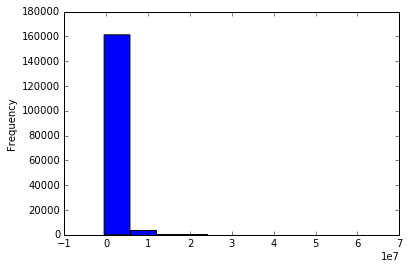

In [22]:
# Histogram of the time for solving an issue
%pylab inline
pandas_ds["time2close"].plot(kind="hist")